In [1]:
import juliacall, juliatorch
from juliacall import JuliaError
import torch
from chirho.contrib.experiments.fishery.build_f import build_steady_state_f, build_temporal_f
import pyro
import pyro.distributions as dist
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import seaborn as sns

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preliminary Setup

In [2]:
# Define helpers that take fishing mortality rates, a parameter dict, and initial biomass, and flattens
#  everything into a single tensor that can be passed to a juliatorch JuliaFunction.
def flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    ps = parameters
    return torch.cat(
        [
            initial_biomass,
            torch.stack([
                ps["r1"],
                ps["k1"],
                ps["p12"],
                ps["d1"],
                torch.abs(fishing_mortality_rates[0]),
                ps["r2"],
                ps["e12"],
                ps["p23"],
                ps["d2"],
                torch.abs(fishing_mortality_rates[1]),
                ps["r3"],
                ps["e23"],
                ps["m3"],
                torch.abs(fishing_mortality_rates[2]),
            ]).squeeze()
        ]
    )

def flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times):
    return torch.cat([flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates), times])

In [3]:
# Construct the python function interface to the underlying julia solver
#  of the Zhou and Smith's fishery model (2017)
fishery_steady_state_solver = build_steady_state_f()
fishery_temporal_solver = build_temporal_f()

In [4]:
# Parameters used by Zhao and Smith (2017). We treat these as the true values.
TRUEVALS = OrderedDict(
    k1=1000.0, r1=2.0, r2=1.0, r3=0.25, p12=0.5, p23=0.5, d1=100.0, d2=10.0, e12=0.2, e23=0.2, m3=0.01
)
for k, v in TRUEVALS.items():
    TRUEVALS[k] = torch.tensor(v).double()

# Used to scale up approximately growth proportional fishing rates to absolute fishing rates.
# Note that these are fixed quantities serving only to transform 0-1 fishing rate parameters to absolute rates.
APPROX_GROWTH_RATES = torch.tensor([TRUEVALS["r1"], TRUEVALS["r2"], TRUEVALS["r3"]]).double()
NUM_SPECIES = 3

In [5]:
# Approximate equilibrium biomass for the unfished case.
B_UNFISHED = torch.tensor([958.833, 174.356, 33.476]).double()

In [6]:
def fishery_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    biomass_eq = fishery_steady_state_solver(flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates))
    # Sometimes the solver goes infinitesimally negative, which can break logs.
    return torch.abs(biomass_eq)

def fishery_at_times(parameters, initial_biomass, fishing_mortality_rates, times):
    return fishery_temporal_solver(flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times))

### Exploitative Fishing

The narrative begins with exploitative fishing that only considers the maximum sustainable revenue (MSR). For simplicity here, we assume the true parameters are known, and the MSR policy is identified based on those parameters. This policy runs for a number of years, and the biomass is noisily observed at the end of each year.

In [7]:
# Define we dub the maximum sustainable revenue, assuming fixed market prices.
PRICES = torch.tensor([1.0, 20.0, 100.0]).double()

def gross_revenue(biomass, mortality, prices):
    return (biomass * mortality * prices).sum()

In [8]:
# Use scipy optimize and the true parameter values to find the MSR fishing rates.
def find_msr_fishing_rates(truevals, initial_biomass, prices):
    def objective(mortality_proportions: np.ndarray):
        mortality_rates = torch.tensor(mortality_proportions).double() * APPROX_GROWTH_RATES
        ss = fishery_steady_state(truevals, initial_biomass, mortality_rates)
        msr = gross_revenue(ss, mortality_rates, prices).sum()
        return -msr

    return optimize.minimize(objective, x0=np.array([0.1, 0.1, 0.1]), bounds=[(0.0, 1.0)] * 3).x

In [9]:
msr_rates = torch.tensor(find_msr_fishing_rates(TRUEVALS, B_UNFISHED, PRICES)).double() * APPROX_GROWTH_RATES

In [10]:
# Plot the biomass over time under the MSR policy.
expl_times = torch.arange(0, 5, 0.5)
expl_biomass_at_times = fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, expl_times)

In [11]:
def plot_biomass_over_time(times, biomass_at_times, logscale=True, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(times, biomass_at_times[0], label="Forage")
    ax.plot(times, biomass_at_times[1], label="Intermediate")
    ax.plot(times, biomass_at_times[2], label="Apex", color="g")
    if logscale:
        ax.set_yscale("log")
    ax.set_ylabel("Biomass")
    ax.set_xlabel("Time")
    ax.legend()
    if show:
        plt.show()
    return fig, ax

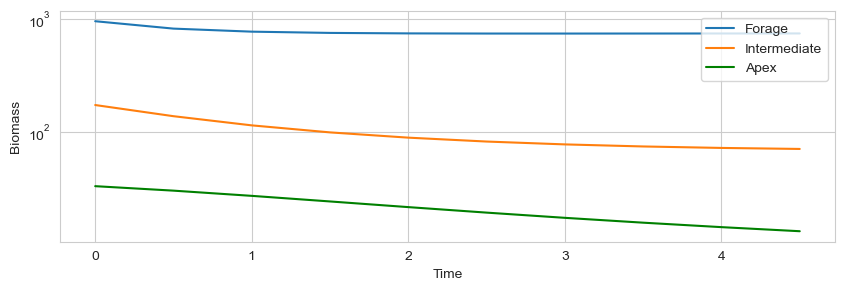

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [12]:
plot_biomass_over_time(expl_times, expl_biomass_at_times)

### Pause on Fishing

The exploitative period ended after concerns developed around the downspin in apex predator numbers. The fishery is paused for a period of time, and the biomass is observed with more frequency.

In [13]:
pause_times = torch.arange(0.1, 1, 0.1)
pause_biomass_at_times = fishery_at_times(TRUEVALS, expl_biomass_at_times[:, -1], torch.zeros_like(msr_rates), pause_times)

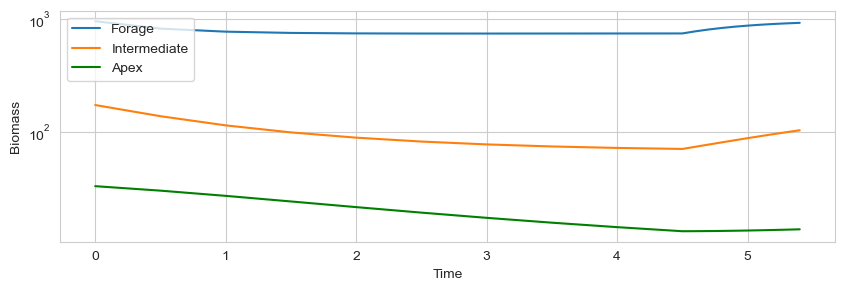

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [14]:
expl_and_pause_times = torch.cat([expl_times, expl_times[-1] + pause_times])
expl_and_pause_biomass_at_times = torch.cat([expl_biomass_at_times, pause_biomass_at_times], dim=1)
plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times)

### Ecologically Aware Fishing

After a few years of exploitative fishing, ecological concerns begin to take more prominence. Our task is to take a high level understanding of fishery parameters (our "prior") and combine that with observed data during the exploitative period. We then seek a new set of fishing rates that also optimize for biodiversity and avoid rare, but catostrophic extinction events.  

#### Prior Definition
TODO port over details from julia file.

In [15]:
# Define prior over parameters of fishery. 
def prior():
    k1 = pyro.sample("k1", dist.LogNormal(loc=6.94, scale=0.18))
    r1 = pyro.sample("r1", dist.LogNormal(loc=0.76, scale=0.59))
    r2 = pyro.sample("r2", dist.LogNormal(loc=0.0, scale=0.42))
    r3 = pyro.sample("r3", dist.LogNormal(loc=-1.3, scale=0.79))
    p12 = pyro.sample("p12", dist.LogNormal(loc=-0.70, scale=1.1))
    p23 = pyro.sample("p23", dist.LogNormal(loc=-0.70, scale=1.1))
    d1 = pyro.sample("d1", dist.LogNormal(loc=4.61, scale=0.42))
    d2 = pyro.sample("d2", dist.LogNormal(loc=2.30, scale=0.42))
    e12 = pyro.sample("e12", dist.LogNormal(loc=-1.97, scale=0.37))
    e23 = pyro.sample("e23", dist.LogNormal(loc=-1.97, scale=0.37))
    m3 = pyro.sample("m3", dist.LogNormal(loc=-4.232, scale=0.6))
    
    return OrderedDict(
        k1=k1, r1=r1, r2=r2, r3=r3, p12=p12, p23=p23, d1=d1, d2=d2, e12=e12, e23=e23, m3=m3
    )

In [16]:
# Plot the marginals for each parameter, alongisde the approximate lower and upper bounds, and the median.
def plot_marginals(samples, truevals=None):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, (name, samples_one_var) in enumerate(samples.items()):
        ax = axs[i // 4, i % 4]
        sns.kdeplot(samples_one_var, ax=ax)
        ax.axvline(torch.median(samples_one_var), color="r", linestyle="--", linewidth=0.1)
        sq = torch.quantile(samples_one_var, 0.025)
        ax.axvline(sq, color="r", linestyle="--", linewidth=0.3)
        lq = torch.quantile(samples_one_var, 0.975)
        ax.axvline(lq, color="r", linestyle="--", linewidth=0.3)
        ax.set_title(name)
        ax.grid(False)
        if truevals is not None:
            ax.axvline(truevals[name], color="k", linestyle="--")
        ax.set_xlim(0.0, lq*1.5)
    plt.tight_layout()
    return fig, axs

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

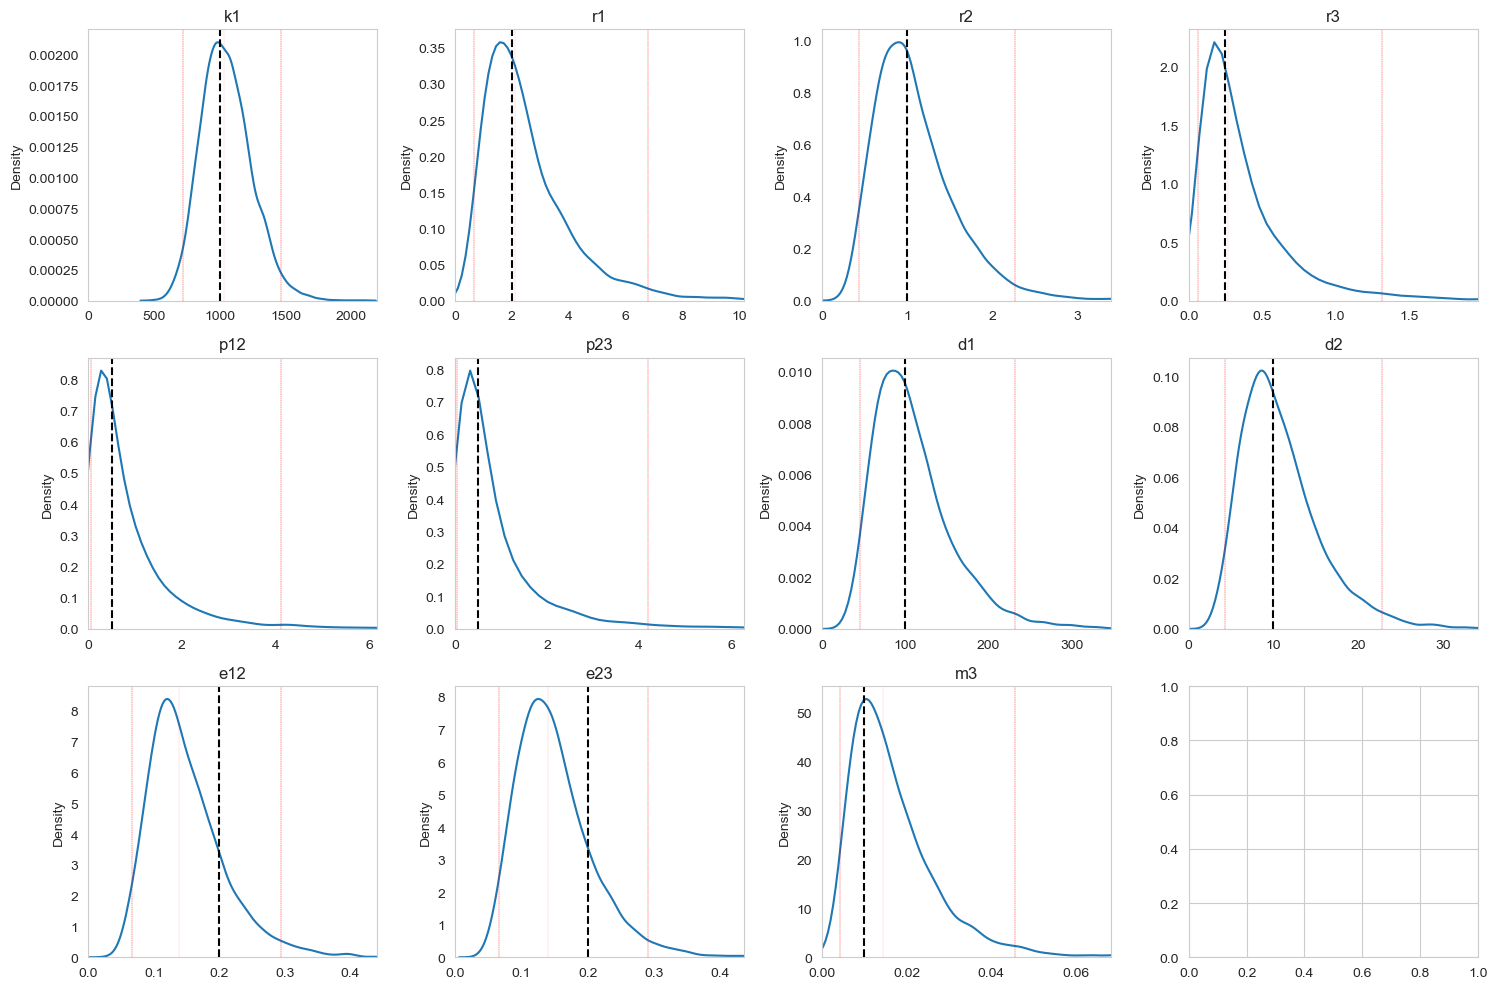

In [17]:
# Sample from the prior
with pyro.plate("samples", 5000):
    plot_marginals(prior(), TRUEVALS)
plt.show()

#### Observation Noise
Realistically, biomass measurements are noisy. We posit a simple roughly 20% relative error in biomass measurements for each trophic level. In reality, of course, this might differ across strata. 

In [18]:
def lognormal_parameters(mu, sigma):
    sigma_log = torch.log(sigma ** 2. / mu ** 2. + 1.0)
    mu_log = torch.log(mu) - 0.5 * sigma_log
    return mu_log, sigma_log

def observation_model(biomass_at_times, obs_str="obs"):
    # Use lognormals just to fold in the positivity constraints.
    unscaled_noise = 0.5
    sigma = (biomass_at_times ** 0.9) * unscaled_noise
    
    mu_log, sigma_log = lognormal_parameters(biomass_at_times, sigma)
    
    return pyro.sample(obs_str, dist.LogNormal(mu_log, sigma_log).to_event(mu_log.ndim))

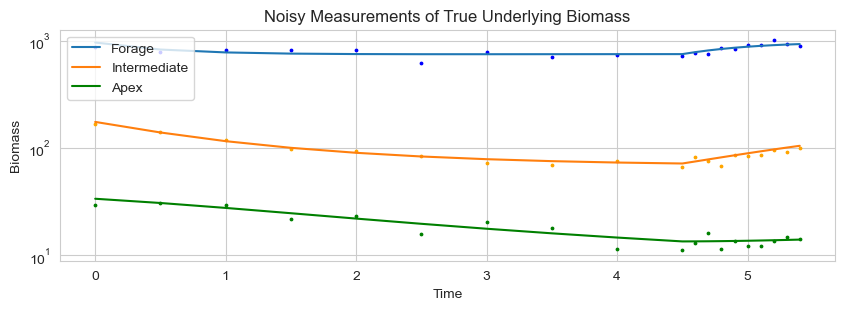

In [19]:
fig, ax = plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times, show=False)

# Plot biomass measurement points.
observed_biomass_at_times = observation_model(expl_and_pause_biomass_at_times)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)
ax.set_title("Noisy Measurements of True Underlying Biomass")
plt.show()

#### Stiching the Model Together
Thus far we've defined a prior, two fishing regimes, and an observation model. We can now stitch these together into a full model. We additionally add prior uncertainty over the initial biomass.

In [20]:
def prior_initial_biomass():
    mu_log, sigma_log = lognormal_parameters(B_UNFISHED, 0.5 * B_UNFISHED)
    return pyro.sample("initial_biomass", dist.LogNormal(loc=mu_log, scale=sigma_log).to_event(1))

def prior_predictive_fishery_model():
    parameters = prior()
    biomass0 = prior_initial_biomass()
    
    # Exploitative period.
    expl_x = flatten_for_temporal(parameters, biomass0, msr_rates, expl_times)
    expl_mean_y = fishery_temporal_solver(expl_x)
    
    # Pause period.
    pause_x = flatten_for_temporal(parameters, expl_mean_y[:, -1], torch.zeros_like(msr_rates), pause_times)
    pause_mean_y = fishery_temporal_solver(pause_x)
    
    return expl_mean_y, pause_mean_y, parameters, biomass0
    
def full_observed_fishery_model():
    expl_mean_y, pause_mean_y, parameters, biomass0 = prior_predictive_fishery_model()
    
    expl_obs_y = observation_model(expl_mean_y, "expl_obs")
    pause_obs_y = observation_model(pause_mean_y, "pause_obs")
    
    return expl_obs_y, pause_obs_y, expl_mean_y, pause_mean_y, parameters, biomass0

#### Visualize Prior Predictive

In [21]:
# Visualize the full model. It should look roughly like what we've plotted above.
obs_expl_biomass_at_times_list, obs_pause_biomass_at_times_list = [], []
mean_expl_biomass_at_times_list, mean_pause_biomass_at_times_list = [], []
for _ in range(1000):
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times, _, _ = full_observed_fishery_model()
    obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times)
    obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times)
    mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times)
    mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times)

obs_expl_biomass_at_times = torch.stack(obs_expl_biomass_at_times_list)
obs_pause_biomass_at_times = torch.stack(obs_pause_biomass_at_times_list)
mean_expl_biomass_at_times = torch.stack(mean_expl_biomass_at_times_list)
mean_pause_biomass_at_times = torch.stack(mean_pause_biomass_at_times_list)

In [22]:
obs_expl_and_pause_biomass_at_times = torch.cat([obs_expl_biomass_at_times, obs_pause_biomass_at_times], dim=-1)
mean_expl_and_pause_biomass_at_times = torch.cat([mean_expl_biomass_at_times, mean_pause_biomass_at_times], dim=-1)

# Get 0.05, 0.5, and 0.95 quantiles for each time point, so we can plot CIs.
obs_expl_and_pause_biomass_at_times_q = torch.quantile(obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
mean_expl_and_pause_biomass_at_times_q = torch.quantile(mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)


In [23]:
def plot_biomass_over_time_with_ci(times, biomass_at_times_q, logscale=True, show=True):
    fig, ax = plot_biomass_over_time(times, biomass_at_times_q[1], logscale, False)
    for i in range(3):
        ax.fill_between(times, biomass_at_times_q[0, i], biomass_at_times_q[2, i], alpha=0.3)
    if show:
        plt.show()
    return fig, ax

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass')

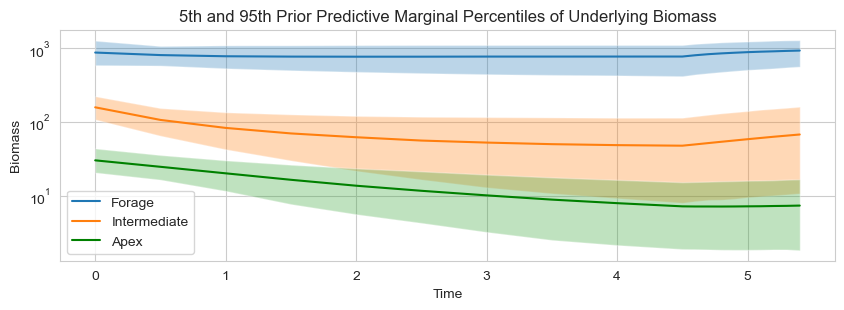

In [24]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, mean_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass")

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements')

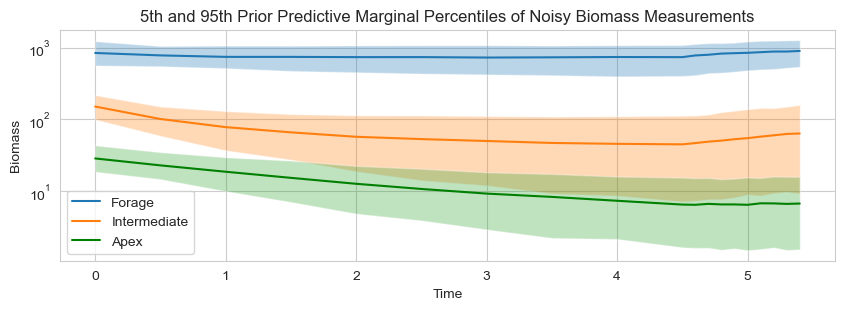

In [25]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, obs_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements")

#### Multi-Objective
After a period of exploitative fishing, policy makers now wish to incorporate ecological objectives. This is formalized as a mult-objective involving a "disturbance index" (Bundy et al. 2005, Zhou and Smith, 2017) that measures the degree of disturbance to the trophic structure relative to the unfished equilibrium state — this acts as a measure of biodiversity. The disturbance index, however, doesn't adequately reflect the  unrecoverable nature of extinction events, so we additionally include a large penalty for cases where the equilibrium state of any trophic level reaches extinction.

In [26]:
def disturbance_index(fished_biomass, unfished_biomass):
    di = 0.0
    for i in range(2):
        di += torch.abs(
            (fished_biomass[i+1] / fished_biomass[i]) - (unfished_biomass[i+1] / unfished_biomass[i])
        )
    return di

def discrete_kl_divergence(p, q):
    return (p * (torch.log(p) - torch.log(q))).sum()
    

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (discrete_kl_divergence(p, m) + discrete_kl_divergence(q, m))

def js_distance(p, q):
    return torch.sqrt(js_divergence(p, q))

def js_disturbance_index(fished_biomass, unfished_biomas):
    # To prevent log(0) issues and instability in proportions when everything goes extinct.
    p = fished_biomass + B_UNFISHED * 1e-2
    q = unfished_biomas + B_UNFISHED * 1e-2
    return js_distance(
        p / p.sum(),
        q / q.sum()
    )

def extinction_event(fished_biomass, unfished_biomass, relaxation=50, threshold=0.03):
    relative_biomass = torch.min(fished_biomass / (unfished_biomass + 1e-6))
    return 1. / (1. + torch.exp(relaxation * (relative_biomass - threshold)))
    

In [27]:
# These different objectives operate on different scales, so we'll need to scale them to be comparable.
 
unfished_ = fishery_steady_state(
    parameters=TRUEVALS,
    initial_biomass=B_UNFISHED,
    fishing_mortality_rates=torch.tensor([0.0, 0.0, 0.0]).double()
)

fisheds = []
mortalities = []

for growth_proportion in range(100):
    mortality = APPROX_GROWTH_RATES * (growth_proportion/100.)
    fished_ = fishery_steady_state(
        parameters=TRUEVALS,
        initial_biomass=B_UNFISHED,
        fishing_mortality_rates=mortality
    )
    fisheds.append(fished_)
    mortalities.append(mortality)

disturbances = torch.stack([disturbance_index(fished, unfished_) for fished in fisheds])
js_disturbances = torch.stack([js_disturbance_index(fished, unfished_) for fished in fisheds])
extinctions = torch.stack([extinction_event(fished, unfished_) for fished in fisheds])
revenues = torch.stack([gross_revenue(
    biomass=fished,
    mortality=mortality,
    prices=PRICES
) for fished, mortality in zip(fisheds, mortalities)])

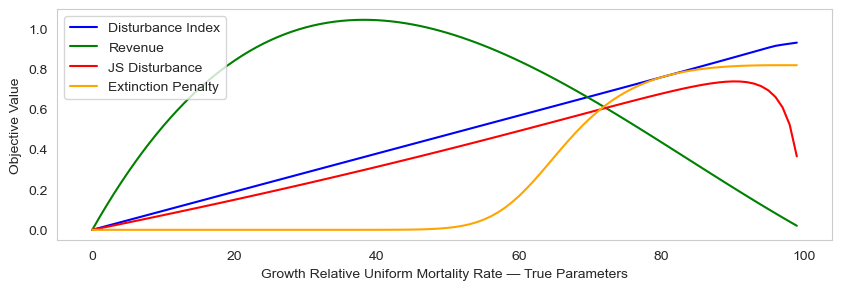

In [28]:
def scale_revenue(revenue):
    return revenue / 1000.0

def scale_disturbance(disturbance):
    return disturbance / 0.4

def scale_js_disturbance(js_disturbance):
    return js_disturbance / .23

def scale_extinction(extinction):
    return extinction

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(scale_disturbance(disturbances), label="Disturbance Index", color="b")
ax.plot(scale_revenue(revenues), label="Revenue", color="g")
ax.plot(scale_js_disturbance(js_disturbances), label="JS Disturbance", color="r")
ax.plot(scale_extinction(extinctions), label="Extinction Penalty", color="orange")

ax.set_xlabel("Growth Relative Uniform Mortality Rate — True Parameters")
ax.set_ylabel("Objective Value")
ax.legend()
ax.grid(False)

### TABDM
TABDM folds inference, prediction, and decision-making together. We'll use it to combine our prior with observed data to prescribe fishing rates that optimize a joint objective. Before, fishery regulators were only interested in maximum sustainable revenue. This led to concerning declines in apex predator numbers. Now, we want to ensure the fishing rates also support biodiversity and avoid rare, but catastrophic extinction events.

In [29]:
def normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates, return_fuf=False):
    fished = fishery_steady_state(
        parameters=parameters,
        initial_biomass=initial_biomass,
        fishing_mortality_rates=fishing_mortality_rates
    )
    
    unfished = fishery_steady_state(
        parameters=parameters,
        initial_biomass=B_UNFISHED,
        fishing_mortality_rates=torch.zeros_like(fishing_mortality_rates)
    )
    
    revenue = scale_revenue(gross_revenue(fished, fishing_mortality_rates, PRICES))
    # disturbance = scale_disturbance(disturbance_index(fished, unfished))
    disturbance = scale_js_disturbance(js_disturbance_index(fished, unfished))
    extinction = scale_extinction(extinction_event(fished, unfished))
    
    if not torch.isfinite(revenue):
        print("revenue", revenue, fished.detach().numpy(), unfished.detach().numpy())
    
    if not torch.isfinite(disturbance):
        print("disturbance", disturbance, fished.detach().numpy(), unfished.detach().numpy())
        
    if not torch.isfinite(extinction):
        print("extinction", extinction, fished.detach().numpy(), unfished.detach().numpy())
    
    ret = OrderedDict(
            revenue=revenue,
            disturbance=disturbance,
            extinction=extinction
        )
    if return_fuf:
        return ret, fished, unfished
    else:
        return ret

#### Sensitivity Analysis
... This provides intuition about where the objectives are large with respect regions of uncertainty.

In [30]:
n = 300
multiobjective_samples = OrderedDict(
    revenue=torch.zeros(n),
    disturbance=torch.zeros(n),
    extinction=torch.zeros(n)
)
multiobjective_gradient_samples = OrderedDict(
    revenue=torch.zeros(n, NUM_SPECIES),
    disturbance=torch.zeros(n, NUM_SPECIES),
    extinction=torch.zeros(n, NUM_SPECIES)
)
fishery_policy_params_sa = (APPROX_GROWTH_RATES.clone() * 0.3).requires_grad_()
# TODO vectorize.
for i in range(n):
    multiobjective_sample, fished, unfished = normalized_multiobjective(
        prior(),
        pause_biomass_at_times[:, -1],
        fishery_policy_params_sa,
        return_fuf=True
    )
    
    for k, v in multiobjective_sample.items():
        multiobjective_samples[k][i] = v.detach()
    
    revenue_gradients = torch.autograd.grad(
        outputs=multiobjective_sample["revenue"],
        inputs=fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    disturbance_gradients = torch.autograd.grad(
        multiobjective_sample["disturbance"],
        fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    extinction_gradients = torch.autograd.grad(
        multiobjective_sample["extinction"],
        fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    # If any gradients are non-finite, identify which one and print out the multi objective
    #  values.
    if not torch.isfinite(revenue_gradients).all():
        print("revenue grad nonfinite", multiobjective_sample)
    if not torch.isfinite(disturbance_gradients).all():
        print("disturbance grad nonfinite", multiobjective_sample)
    if not torch.isfinite(extinction_gradients).all():
        print("extinction grad nonfinite", multiobjective_sample)
    
    if (torch.abs(disturbance_gradients) > 30).any():
        # So the disturbance gradient becomes very large and kind of random when everything goes extinct.
        # The intuition is that tiny changes in fishing pressure in this regime will cause massive changes
        #  to the relative biomass between species (and is probably dominated by solver instability anyway).
        print("-----------------")
        print("disturbance grad large")
        print("fished", fished.detach().numpy())
        print("unfished", unfished.detach().numpy())
        print("disturbance", multiobjective_sample["disturbance"])
        print("gradient", disturbance_gradients.detach().numpy())
        print("-----------------")
    
    for k, v in multiobjective_gradient_samples.items():
        v[i, :] = locals()[f"{k}_gradients"].detach()

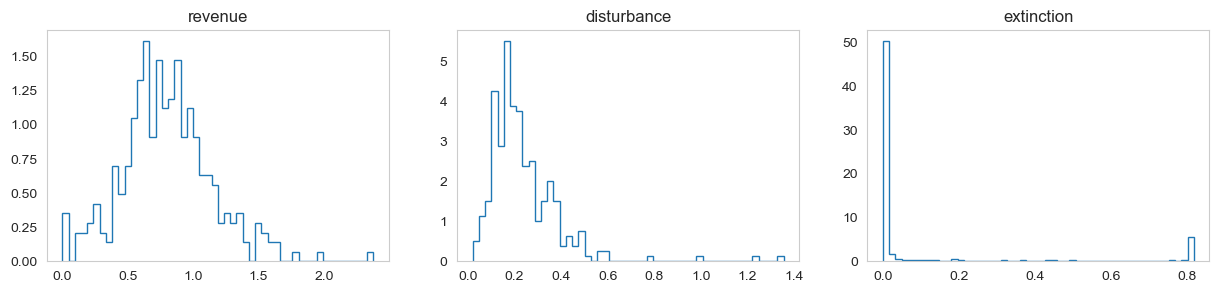

In [31]:
# First, plot the marginals of the objectives.
_, axs = plt.subplots(1, 3, figsize=(15, 3))
for i, (name, samples_one_var) in enumerate(multiobjective_samples.items()):
    ax = axs[i]
    ax.grid(False)
    # sns.kdeplot(samples_one_var, ax=ax)
    ax.hist(samples_one_var, bins=50, histtype="step", density=True)
    ax.set_title(name)

------revenue-------
------Species 0-------
Mean tensor(0.0610)
QL tensor(-0.3887)
QM tensor(0.1980)
QH tensor(0.5488)
Max tensor(1.1080)
Min tensor(-2.5520)
%Finite tensor(1.)
------Species 1-------
Mean tensor(0.5400)
QL tensor(0.0286)
QM tensor(0.5425)
QH tensor(1.0485)
Max tensor(2.9715)
Min tensor(-1.7223)
%Finite tensor(1.)
------Species 2-------
Mean tensor(0.5164)
QL tensor(0.0641)
QM tensor(0.3865)
QH tensor(0.9047)
Max tensor(3.7788)
Min tensor(-1.4290)
%Finite tensor(1.)
------disturbance-------
------Species 0-------
Mean tensor(0.0574)
QL tensor(-0.0308)
QM tensor(-0.0095)
QH tensor(-0.0025)
Max tensor(25.7936)
Min tensor(-1.3021)
%Finite tensor(1.)
------Species 1-------
Mean tensor(0.7006)
QL tensor(0.2725)
QM tensor(0.5552)
QH tensor(0.9667)
Max tensor(4.6277)
Min tensor(-1.3587)
%Finite tensor(1.)
------Species 2-------
Mean tensor(0.2888)
QL tensor(-0.0742)
QM tensor(0.0867)
QH tensor(0.5622)
Max tensor(7.7045)
Min tensor(-2.6338)
%Finite tensor(1.)
------extinction--

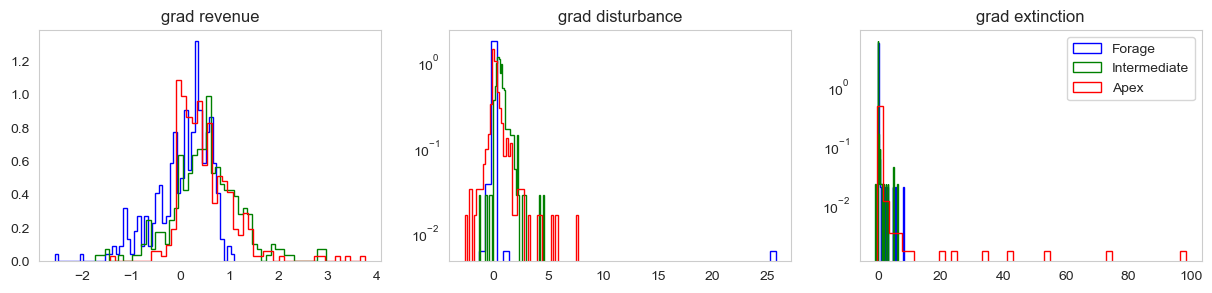

In [32]:
# Now plot the three partials for each component objective in a similar subplot arrangement, but with three lines plotted in each subplot
_, axs = plt.subplots(1, 3, figsize=(15, 3))
colors = ["b", "g", "r"]
labels = ["Forage", "Intermediate", "Apex"]
for i, (name, gradient_samples_one_var) in enumerate(multiobjective_gradient_samples.items()):
    ax = axs[i]
    ax.grid(False)
    print(f"------{name}-------")
    for j in range(NUM_SPECIES):
        # sns.kdeplot(gradient_samples_one_var[:, j], ax=ax, gridsize=1000)
        # hist without filling.
        ax.hist(gradient_samples_one_var[:, j], bins=50, histtype="step", density=True,
                label=labels[j], color=colors[j])
        print(f"------Species {j}-------")
        print("Mean", gradient_samples_one_var[:, j].mean())
        print("QL", gradient_samples_one_var[:, j].quantile(0.2))
        print("QM", gradient_samples_one_var[:, j].quantile(0.5))
        print("QH", gradient_samples_one_var[:, j].quantile(0.8))
        print("Max", gradient_samples_one_var[:, j].max())
        print("Min", gradient_samples_one_var[:, j].min())
        print("%Finite", torch.isfinite(gradient_samples_one_var[:, j]).float().mean())
    ax.set_title(f"grad {name}")

# axs[0].set_xlim(-3, 3)
# axs[1].set_xlim(-1, 2)
# axs[2].set_xlim(-10, 10)
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[2].legend()

#### TABDM Decomposition
In our setting, the optimal proposals for revenue and the disturbance index are slightly skewed, but not particularly heavy-tailed. The extinction penalty, however, shows a small mode in the tails around catostrophic extinctions, and is likely to benefit from target aware approaches. Thus, while we employ the TABI decomposition for revenue and disturbance to debias them, we simply use the posterior approximation as the proposal for all components.

For the extinction event, however, we employ both the full- and single-TABDM approaches with both mixtures of gaussians and expressive normalizing flows. These are further compared to the biased and untargeted monte-carlo approach using a posterior approximation, and PAIS, which does utilize vanilla importance sampling to target the extinction event by incorrectly assuming the posterior approximation is true.

We show weighted, high-sample estimates of the multi-objective at a few checkpoints in the optimization process.

In [33]:
# Aspects of the multi-objective that aren't tail-heavy.
def build_rescaled_revenue_and_disturbance_f(fishing_mortality_rates, objective_scaling_dict):
    def rescaled_revenue_and_disturbance_f(stochastics):
        initial_biomass = stochastics.pop("initial_biomass")
        parameters = stochastics
        multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
        
        rescaled_revenue = multiobjective["revenue"] * objective_scaling_dict["revenue"]
        rescaled_disturbance = multiobjective["disturbance"] * objective_scaling_dict["disturbance"]
        
        return rescaled_revenue + rescaled_disturbance
    
    return rescaled_revenue_and_disturbance_f

# Aspect of the multi-objective that is tail-heavy.
def build_rescaled_extinction_f(fishing_mortality_rates, objective_scaling_dict):
    def rescaled_extinction_f(stochastics):
        initial_biomass = stochastics.pop("initial_biomass")
        parameters = stochastics
        multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
        
        rescaled_extinction = multiobjective["extinction"] * objective_scaling_dict["extinction"]
        
        return rescaled_extinction
    return rescaled_extinction_f

# Just the full multiobjective.
def build_full_rescaled_multiobjective_f(fishing_mortality_rates, objective_scaling_dict):
    def full_rescaled_multiobjective_f(stochastics):
        initial_biomass = stochastics.pop("initial_biomass")
        parameters = stochastics
        multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
        
        rescaled_revenue = multiobjective["revenue"] * objective_scaling_dict["revenue"]
        rescaled_disturbance = multiobjective["disturbance"] * objective_scaling_dict["disturbance"]
        rescaled_extinction = multiobjective["extinction"] * objective_scaling_dict["extinction"]
        
        return rescaled_revenue + rescaled_disturbance + rescaled_extinction
    return full_rescaled_multiobjective_f


def build_jac(fishing_mortality_rates, obj_fn):
    def jac(stochastics):
        obj_val = obj_fn(stochastics)
        
        return torch.autograd.grad(
            obj_val,
            fishing_mortality_rates,
            retain_graph=True
        )[0]
    
    return jac

In [34]:
def build_fit_variational_approximation(pseudo_density, guide, lr):
    elbo = pyro.infer.Trace_ELBO()(pseudo_density, guide)
    elbo()
    optim = torch.optim.Adam(elbo.parameters(), lr=lr)
    
    def fit_variational_approximation():
        for _ in range(5): # 5 retries
            for param in elbo.parameters():
                param.grad = None
            optim.zero_grad()
            
            try:
                loss = elbo()
                loss.backward()
            # This can be biased. In our setting, it generally won't be though because the system is stable
            #  around likely parameters.
            except JuliaError:
                print("Failed pseudo density solve, retrying...this may result in bias.")
                continue
    
            optim.step()
            break
    
    return fit_variational_approximation

In [35]:
def build_step_policy_param(fishing_mortality_rates, lr, clip):
    optim = torch.optim.SGD((fishing_mortality_rates,), lr=lr)
    one = torch.tensor(1.)
    
    def step_policy_param(grad_estimate):
        optim.zero_grad()
        fishing_mortality_rates.grad = None
        
        clipped_grad_estimate = grad_estimate * torch.min(one, clip / torch.linalg.norm(grad_estimate))
        
        fishing_mortality_rates.grad = clipped_grad_estimate
        optim.step()
    
    return step_policy_param

In [36]:
conditioned_model = pyro.condition(full_observed_fishery_model, data=dict(
    expl_obs=observed_biomass_at_times[:, :len(expl_times)], pause_obs=observed_biomass_at_times[:, len(expl_times):]
))

In [37]:
OBJECTIVE_SCALING_DICT = dict(
    revenue=1.0,
    disturbance=1.0,
    extinction=10.0,
)

In [38]:
from chirho.contrib.compexp.utils import kft

# First, set up Posterior-Approximation Monte Carlo. This will simply update the posterior approximation, sample from it, and then push that through the model gradients.
def pamc(model, guide, svi_lr: float, fpo_lr: float, fpo_clip: float, burnin_iters: int, opt_iters: int):
    
    fit_posterior = build_fit_variational_approximation(
        pseudo_density=model,
        guide=guide,
        lr=svi_lr
    )
    
    fishing_policy_params = msr_rates.detach().clone().requires_grad_()
    multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, OBJECTIVE_SCALING_DICT)
    multiobjective_grad = build_jac(fishing_policy_params, multiobjective)
    step_policy_param = build_step_policy_param(fishing_policy_params, fpo_lr, fpo_clip)
    
    for i in range(burnin_iters):
        fit_posterior()
        
    yield fishing_policy_params.detach().clone()
    
    for i in range(burnin_iters, burnin_iters + opt_iters):
        fit_posterior()
        
        for _ in range(5):
            guide_trace = pyro.poutine.trace(guide).get_trace()
            stochastics = kft(guide_trace)
            
            try:
                grad_estimate = multiobjective_grad(stochastics)
                if not torch.isfinite(grad_estimate).all():
                    raise JuliaError(Exception())
            except JuliaError:
                print("Failed steady state solve, retrying...this may result in bias.")
                # print(stochastics)
                continue
            
            step_policy_param(grad_estimate)
            break
        
        yield fishing_policy_params.detach().clone()

In [39]:
from pyro.infer.autoguide.initialization import init_to_value
import time

pamc_model = conditioned_model
pamc_guide = pyro.infer.autoguide.AutoMultivariateNormal(
    pamc_model,
    # TODO WIP need to figure out LogNormal parameters s.t. we can multiply up to proper scale for all params,
    #  from e.g. unit scale. That way this single scale parameter will actually initialize decently.
    init_scale=1.0,
    init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()})
)

pamc_start_t = time.time()
pamc_result = torch.stack([params for params in pamc(
    model=pamc_model,
    guide=pamc_guide,
    svi_lr=1e-3,
    fpo_lr=1e-2,
    fpo_clip=10.0,
    burnin_iters=5000,
    opt_iters=5000
)])
print("pamc wall time", time.time() - pamc_start_t)

pamc wall time 248.81541681289673


In [40]:
def plot_parameter_optimization(results):
    np_results = results.numpy().T
    plt.figure()
    plt.plot(np_results[0], label="Forage")
    plt.plot(np_results[1], label="Intermediate")
    plt.plot(np_results[2], label="Apex")

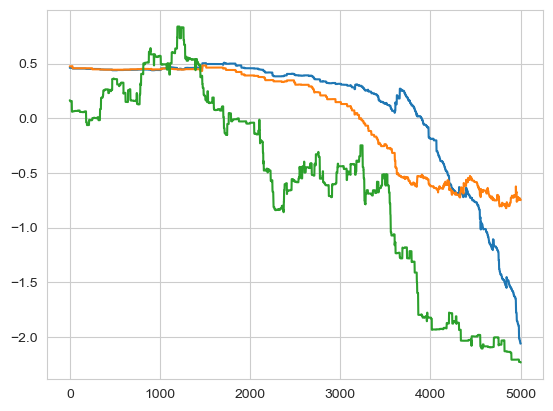

In [41]:
plot_parameter_optimization(pamc_result)

In [42]:
# TODO generate samples from the resultant posterior, just to sanity check that. Emulate prior marginal plots. This will require drawing from guide, probably kft-ing them, and stacking them together in a result?

# Start by generating samples from the guide, using keys from true vals.
n = 1000
pamc_posterior_samples = OrderedDict(
    {k: torch.zeros(n) for k in TRUEVALS.keys()}
)
traces = []

for i in range(n):
    guide_trace = pyro.poutine.trace(pamc_guide).get_trace()
    traces.append(guide_trace)
    stochastics = kft(guide_trace)
    
    for k, v in pamc_posterior_samples.items():
        pamc_posterior_samples[k][i] = stochastics[k].detach()

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

(<Figure size 1500x1000 with 12 Axes>,
 array([[<Axes: title={'center': 'k1'}, ylabel='Density'>,
         <Axes: title={'center': 'r1'}, ylabel='Density'>,
         <Axes: title={'center': 'r2'}, ylabel='Density'>,
         <Axes: title={'center': 'r3'}, ylabel='Density'>],
        [<Axes: title={'center': 'p12'}, ylabel='Density'>,
         <Axes: title={'center': 'p23'}, ylabel='Density'>,
         <Axes: title={'center': 'd1'}, ylabel='Density'>,
         <Axes: title={'center': 'd2'}, ylabel='Density'>],
        [<Axes: title={'center': 'e12'}, ylabel='Density'>,
         <Axes: title={'center': 'e23'}, ylabel='Density'>,
         <Axes: title={'center': 'm3'}, ylabel='Density'>, <Axes: >]],
       dtype=object))

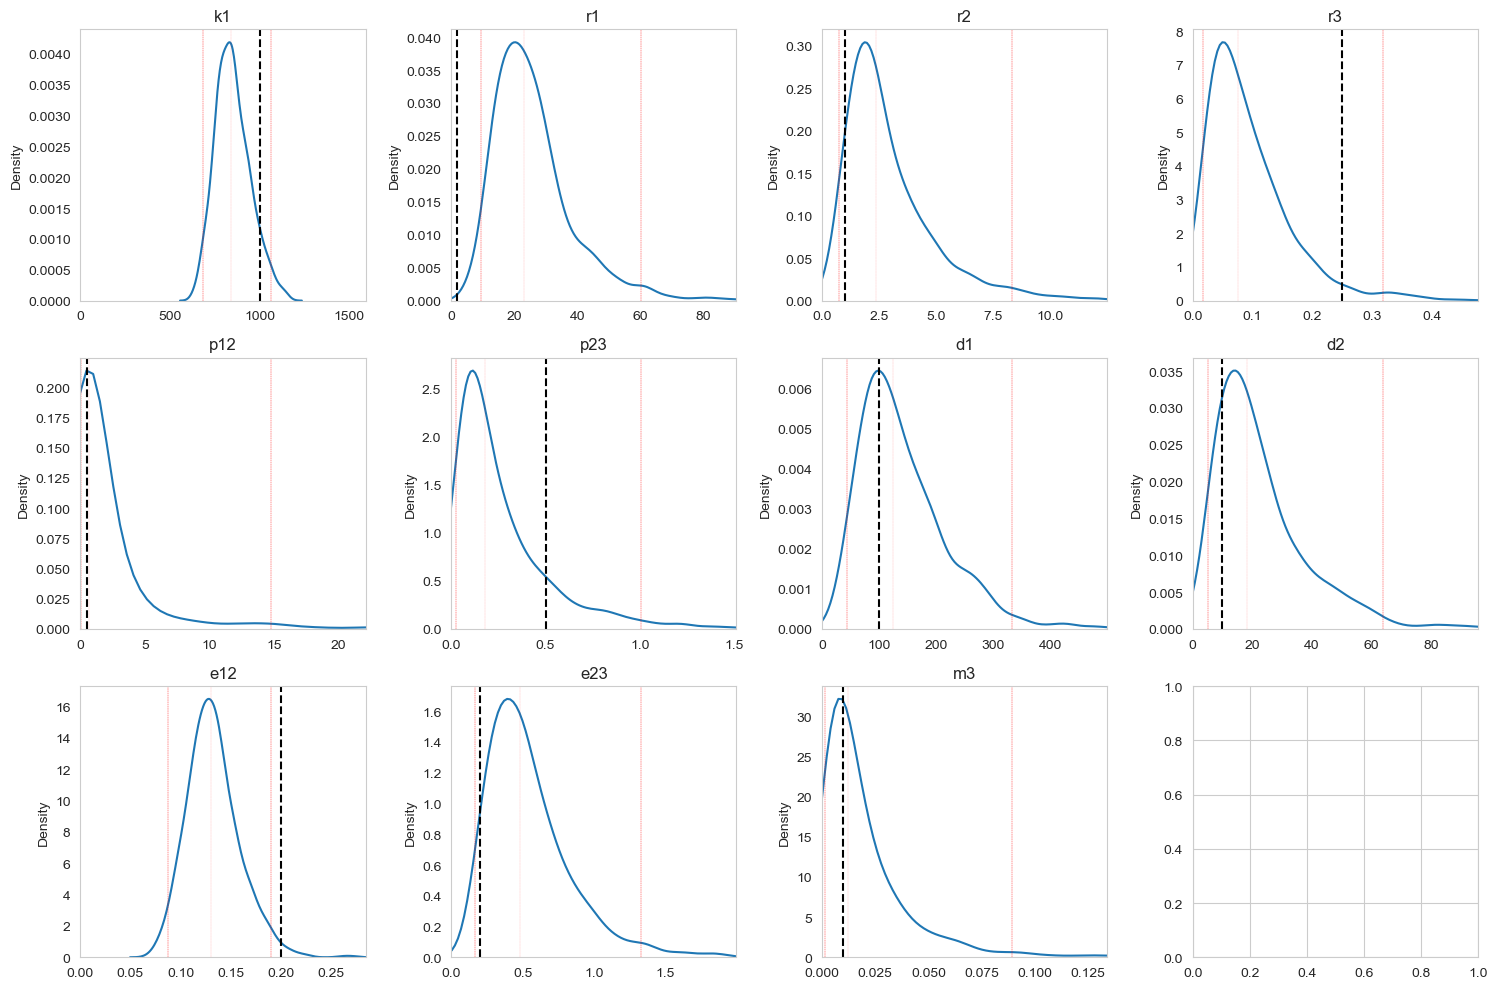

In [43]:
plot_marginals(pamc_posterior_samples, TRUEVALS)

In [44]:
# Plot posterior predictive.
pamc_obs_expl_biomass_at_times_list, pamc_obs_pause_biomass_at_times_list = [], []
pamc_mean_expl_biomass_at_times_list, pamc_mean_pause_biomass_at_times_list = [], []
# Use replay to play the guide trace through the fully observed temporal model.
for trace in traces:
    res = pyro.poutine.replay(full_observed_fishery_model, trace)()
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times, _, _ = res
    
    pamc_obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times.detach())
    pamc_obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times.detach())
    pamc_mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times.detach())
    pamc_mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times.detach())
    
pamc_obs_expl_biomass_at_times = torch.stack(pamc_obs_expl_biomass_at_times_list)
pamc_obs_pause_biomass_at_times = torch.stack(pamc_obs_pause_biomass_at_times_list)
pamc_mean_expl_biomass_at_times = torch.stack(pamc_mean_expl_biomass_at_times_list)
pamc_mean_pause_biomass_at_times = torch.stack(pamc_mean_pause_biomass_at_times_list)

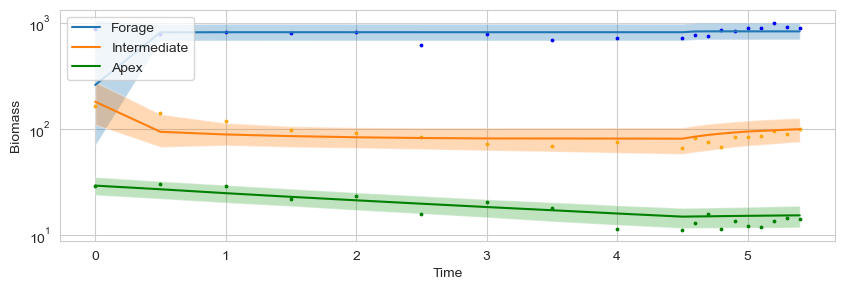

In [45]:
# Plot the posterior predictive.
pamc_obs_expl_and_pause_biomass_at_times = torch.cat([pamc_obs_expl_biomass_at_times, pamc_obs_pause_biomass_at_times], dim=-1).detach()
pamc_mean_expl_and_pause_biomass_at_times = torch.cat([pamc_mean_expl_biomass_at_times, pamc_mean_pause_biomass_at_times], dim=-1).detach()

pamc_obs_expl_and_pause_biomass_at_times_q = torch.quantile(pamc_obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
pamc_mean_expl_and_pause_biomass_at_times_q = torch.quantile(pamc_mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)

_, ax = plot_biomass_over_time_with_ci(expl_and_pause_times, pamc_mean_expl_and_pause_biomass_at_times_q, show=False)

# And plot the original data with a scatter. The stuff that's being conditioned on in the model.
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)

In [46]:
# TODO WIP to sanity check this, see if maximum sustainable yield objective scaling converges to the msr_rates